# Training the House Plant Model
The purpose of this notebook is to allow modifications to the model to be made without having to re-run every kernel

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

# Imports
import os, warnings
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from pathlib import Path
import imghdr

2024-12-23 21:13:36.059868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735006416.162463  187320 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735006416.192302  187320 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-23 21:13:36.431463: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load dataset
dataset_path = "house_plant_species"

# only keep supported formats like .jpg, .jpeg, .png
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

### Removing Unwanted Data
Tensor Flow is very picky with what data it wants. This code block only needs to be ran once but allowed me to remove the data that did not work from the directory `house_plant_species`

In [ ]:
# sourced from: https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required
from pathlib import Path
import imghdr

# Point to current directories and valid types
data_dir = dataset_path
image_extensions = valid_extensions  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

### Loading the Data
Next, we'll load all of the data to be ready for training.

In [3]:
# Set up reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 13724 files belonging to 47 classes.


I0000 00:00:1735006431.069376  187320 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 13724 files belonging to 47 classes.


In [25]:
# understood how to handle the imbalance through: https://www.kaggle.com/code/muhammadfaizan65/plant-species-classification-vgg16#about-the-dataset
from sklearn.utils import class_weight

# since we get our labels from the folder structure, grabs labels and convert to integer indices
train_labels = np.concatenate([y.numpy() for _, y in ds_train_])
train_labels = np.argmax(train_labels, axis=1)

class_weights = dict(enumerate(class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_labels), 
    y=train_labels)))

2024-12-23 18:38:30.585980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate
2024-12-23 18:38:31.149204: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-23 18:38:31.280482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-23 18:38:40.263391: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-23 18:38:42.926706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-23 18:38:43.418112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-23 18:38:45.337261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-23 18:38:45.788793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-23 18:38:46.418377: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: know

In [26]:
print("Class weights:", class_weights)

Class weights: {0: np.float64(0.9012345679012346), 1: np.float64(1.3333333333333333), 2: np.float64(0.73), 3: np.float64(1.6590909090909092), 4: np.float64(1.825), 5: np.float64(1.489795918367347), 6: np.float64(1.8024691358024691), 7: np.float64(1.020979020979021), 8: np.float64(1.0579710144927537), 9: np.float64(0.9358974358974359), 10: np.float64(1.140625), 11: np.float64(0.8848484848484849), 12: np.float64(0.5851703406813628), 13: np.float64(0.9765886287625418), 14: np.float64(1.4527363184079602), 15: np.float64(0.9511400651465798), 16: np.float64(0.7121951219512195), 17: np.float64(1.2863436123348018), 18: np.float64(0.5748031496062992), 19: np.float64(0.948051948051948), 20: np.float64(1.3773584905660377), 21: np.float64(0.9419354838709677), 22: np.float64(1.168), 23: np.float64(1.0318021201413428), 24: np.float64(2.28125), 25: np.float64(0.6252676659528907), 26: np.float64(0.731829573934837), 27: np.float64(0.8613569321533924), 28: np.float64(0.6212765957446809), 29: np.float64(

### Training
Next, we'll train and take a look at the model's performance using some augmented training data. Some warnings arise due to incorrect `sRGB`profiles; however this will not affect the model's accuracy or performance so I will ignore it for the most part.

In [7]:
# Define the model
num_classes = 47  

model = keras.Sequential([

    layers.Input(name='image_bytes', shape=(128, 128, 3)), # Give image_bytes parameter so serving will process

    # Resize the input images for simplicity; no need for a proxy in the pipeline
    layers.Resizing(128, 128),

    # Data Augmentation
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.10),
    layers.RandomContrast(factor=0.10),
    #layers.RandomWidth(factor=0.15),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),  # Multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class
    metrics=['accuracy'],
)



In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Number of epochs to wait for improvement
    restore_best_weights=True,    # Restore the best weights after stopping
    verbose=1                     # Print a message when stopping
)

# Train the model using adjusted class weights
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,                      # we will try 50 epochs if this doesnt predict too well
    batch_size=64,
    #class_weight=class_weights,    # we have to normalize this TODO: make sure ints and strings map properly - we might not need it since imabalance is not great enough
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 47s 216ms/step - accuracy: 0.7492 - loss: 0.8179 - val_accuracy: 0.6475 - val_loss: 1.2652
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.7462 - loss: 0.8248 - val_accuracy: 0.6366 - val_loss: 1.3160
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.7685 - loss: 0.7687 - val_accuracy: 0.6728 - val_loss: 1.2965
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.7636 - loss: 0.7474 - val_accuracy: 0.7150 - val_loss: 0.9700
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.7863 - loss: 0.6897 - val_accuracy: 0.7129 - val_loss: 1.0031
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8036 - loss: 0.6439 - val_accuracy: 0.6845 - val_loss: 1.2317
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.7994 - loss: 0.6499 - val_accuracy: 0.7091 - val_loss: 1.0598
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.8050 - loss: 0.6254 -

### Plotting and Understanding the Data
Finally, it is a good idea to observe the accuracy of the model to see whether any issues of over or under fitting arise.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,070,695 (107.08 MB)

 Trainable params: 9,356,597 (35.69 MB)

 Non-trainable params: 902 (3.52 KB)

 Optimizer params: 18,713,196 (71.39 MB)

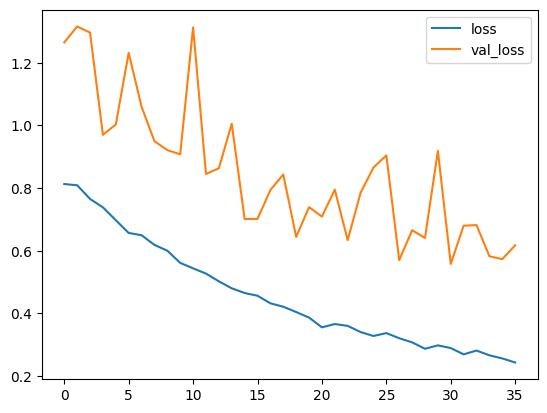

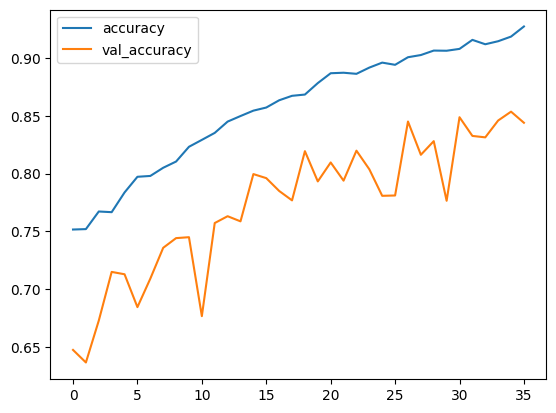

In [11]:
# Plot training history
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Print model summary to verify architecture
model.summary()

### Saving and Exporting the Model
Now that I am satisfied with the output of the model, I will save the model for use in my main program.

In [36]:
model.export("model/plant_model/1") # save as version 1 since we are using TensorFlow Serve which requires a version number

INFO:tensorflow:Assets written to: model/plant_model/1/assets


INFO:tensorflow:Assets written to: model/plant_model/1/assets


Saved artifact at 'model/plant_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='image_bytes')
Output Type:
  TensorSpec(shape=(None, 47), dtype=tf.float32, name=None)
Captures:
  140374228140800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228143088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228145200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228231520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228233280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228230288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228232048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228232224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228234160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140374228234512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14037422823

### Run and Test Locally
Now that we have a model saved, we must make sure to download **Docker** for [Ubuntu](https://docs.docker.com/engine/install/ubuntu/. Once this is taken care of, we can run the following command in the terminal to locally

```
sudo docker run -p 8501:8501 --name=tf_serving \
    --mount type=bind,source=$(pwd)/backend/model/plant_model,target=/models/plant_model \
    -e MODEL_NAME=plant_model \
    -e TF_SERVING_CORS_ALLOW_ORIGINS="http://127.0.0.1:5173" \
    --rm \
    -t tensorflow/serving

cd frontend/plant_tracker_front
npm run dev
```

This will make the page accessible on your local machine as `http://localhost:8501/v1/model/plant_model`

### Problem: Labels
This model currently does not return the label of the highest prediction. To solve this issue, we'll create a V2 which will return the predicted name (based on the dataset) with the highest value.

In [4]:
# Check the class names
class_names = ds_train_.class_names
print("Class Names:", class_names)

Class Names: ['African Violet (Saintpaulia ionantha)', 'Aloe Vera', 'Anthurium (Anthurium andraeanum)', 'Areca Palm (Dypsis lutescens)', 'Asparagus Fern (Asparagus setaceus)', 'Begonia (Begonia spp.)', 'Bird of Paradise (Strelitzia reginae)', 'Birds Nest Fern (Asplenium nidus)', 'Boston Fern (Nephrolepis exaltata)', 'Calathea', 'Cast Iron Plant (Aspidistra elatior)', 'Chinese Money Plant (Pilea peperomioides)', 'Chinese evergreen (Aglaonema)', 'Christmas Cactus (Schlumbergera bridgesii)', 'Chrysanthemum', 'Ctenanthe', 'Daffodils (Narcissus spp.)', 'Dracaena', 'Dumb Cane (Dieffenbachia spp.)', 'Elephant Ear (Alocasia spp.)', 'English Ivy (Hedera helix)', 'Hyacinth (Hyacinthus orientalis)', 'Iron Cross begonia (Begonia masoniana)', 'Jade plant (Crassula ovata)', 'Kalanchoe', 'Lilium (Hemerocallis)', 'Lily of the valley (Convallaria majalis)', 'Money Tree (Pachira aquatica)', 'Monstera Deliciosa (Monstera deliciosa)', 'Orchid', 'Parlor Palm (Chamaedorea elegans)', 'Peace lily', 'Poinsetti

In [6]:
class LabeledModel(tf.keras.Model):
    def __init__(self, base_model, class_names):
        super().__init__()
        self.base_model = base_model
        self.class_names = tf.constant(class_names)

    def call(self, inputs):
        probabilities = self.base_model(inputs)  # Raw predictions
        predicted_indices = tf.argmax(probabilities, axis=-1)  # Predicted indices
        predicted_labels = tf.gather(self.class_names, predicted_indices)  # Class names
        return {"probabilities": probabilities, "labels": predicted_labels}

# Wrap the model
labeled_model = LabeledModel(model, class_names)

# Build the model by passing an example input
example_input = tf.random.normal([1, 128, 128, 3])  # Example input shape (batch_size, height, width, channels)
labeled_model(example_input)  # This triggers the building of the model

# Now export the labeled model
labeled_model.export("model/plant_model/2")


INFO:tensorflow:Assets written to: model/plant_model/2/assets


INFO:tensorflow:Assets written to: model/plant_model/2/assets


Saved artifact at 'model/plant_model/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Output Type:
  Dict[['probabilities', TensorSpec(shape=(None, 47), dtype=tf.float32, name=None)], ['labels', TensorSpec(shape=(None,), dtype=tf.string, name=None)]]
Captures:
  140240280954384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240280958256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240280955968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240281337552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240281335792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240281337200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240281328224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240281334560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140240281649744: TensorSpec(shape=(), dtype=tf.resource, name=None)


### Run Version 2
We will specify the version and run, now the `.json` contains a "labels" field

```
sudo docker run -p 8501:8501 --name=tf_serving \
    --mount type=bind,source=$(pwd)/backend/model/plant_model,target=/models/plant_model \
    -e MODEL_NAME=plant_model \
    -e MODEL_VERSION=2 \
    -e TF_SERVING_CORS_ALLOW_ORIGINS="http://127.0.0.1:5173" \
    --rm \
    -t tensorflow/serving

cd frontend/plant_tracker_front
npm run dev
```